In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Convolutional neural networks

see https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd

see [filter activation demo](http://ml4a.github.io/demos/convolution_all/) [confusion matrix](http://ml4a.github.io/demos/confusion_cifar/)


Tenemos un pequeño dataset de imágenes basado en [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

- cada imagen es de **32x32x3**.
- las imágenes se **linearizan** para la red que ensamblamos con Keras, compuesta por capas tradicionales (**Dense**).
- en ejemplos más sofisticados usaríamos **capas convolucionales** que explotan las correlaciones 2D propias de las imágenes.

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

--2018-11-02 09:34:38--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5’

mini_cifar.h5       100%[===================>]  14.12M  3.75MB/s    in 4.1s    

2018-11-02 09:34:42 (3.45 MB/s) - ‘mini_cifar.h5’ saved [14803609/14803609]



In [3]:
def show_image_mosaic(imgs, labels, figsize=(12, 12), idxs=None):

    plt.figure(figsize=figsize)
    for labi,lab in [i for i in enumerate(np.unique(labels))]:
        k = imgs[labels == lab]
        _idxs = idxs[:10] if idxs is not None else np.random.permutation(len(k))[:10]
        for i, idx in enumerate(_idxs):
            if i == 0:
                plt.subplot(10, 11, labi*11+1)
                plt.title("LABEL %d" % lab)
                plt.plot(0, 0)
                plt.axis("off")

            img = k[idx]
            plt.subplot(10, 11, labi*11+i+2)
            plt.imshow(img, cmap=plt.cm.Greys_r)
            plt.axis("off")

In [4]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

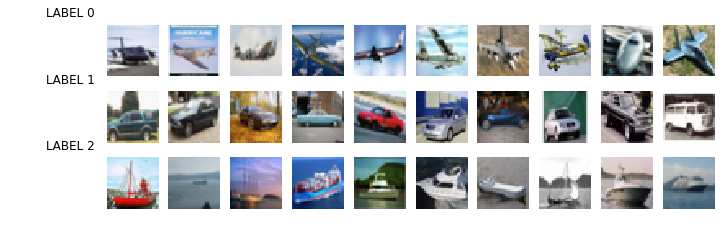

In [5]:
show_image_mosaic(x_cifar, y_cifar)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    764
0    760
1    729
dtype: int64

distribution of test classes
2    261
1    245
0    245
dtype: int64


construimos el modelo con Keras

In [8]:
num_classes = len(np.unique(y_cifar))
num_classes

3

In [9]:
def get_model(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Flatten(name="flatten")(inputs)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu, name="dense_1")(layers)
    layers = tf.keras.layers.Dropout(0.2, name="dropout")(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [10]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)

using 3 classes


observa los pesos inicializados y sus tamaños

In [12]:
weights = model.get_weights()
for i in weights:
    print i.shape

(3072, 16)
(16,)
(16, 3)
(3,)


In [15]:
weights[2]

array([[ 0.52949244, -0.40213245, -0.02422124],
       [ 0.30080777,  0.47924572, -0.33758053],
       [ 0.33706254, -0.07654339,  0.22504902],
       [ 0.02099931, -0.39427295,  0.07944006],
       [-0.5204129 , -0.21885082, -0.5581963 ],
       [-0.13166398, -0.12955084, -0.3377661 ],
       [ 0.38381493,  0.00241017, -0.4157669 ],
       [ 0.27006108,  0.44683617, -0.19411027],
       [ 0.07695109, -0.06653324,  0.13316709],
       [-0.19192547,  0.3135509 ,  0.5566706 ],
       [ 0.2203793 , -0.32394877,  0.06012791],
       [ 0.44522303,  0.00252336, -0.14752194],
       [ 0.40686035,  0.5524041 , -0.5159446 ],
       [-0.32357615,  0.13927507,  0.39970207],
       [ 0.37223315, -0.31173304,  0.13440639],
       [-0.28792927,  0.28574634, -0.04372895]], dtype=float32)

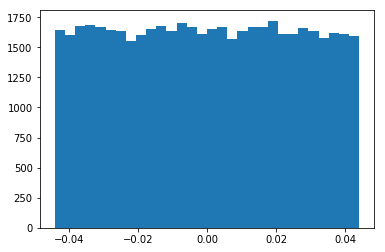

In [13]:
w1 = weights[0]
w1.shape
plt.hist(w1.flatten(), bins=30);

In [14]:
num_classes = len(np.unique(y_cifar))

model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()), write_grads=True, write_images=True)
model.reset_states()
model.fit(x_train, y_train, epochs=5, callbacks=[tensorboard],steps_per_epoch=10)
model.evaluate(x_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 4s 397ms/step - loss: 1.2491 - acc: 0.3376
Epoch 2/5
10/10 [==============================] - 1s 74ms/step - loss: 1.0950 - acc: 0.3192
Epoch 3/5
10/10 [==============================] - 1s 72ms/step - loss: 1.0865 - acc: 0.3111
Epoch 4/5
10/10 [==============================] - 1s 75ms/step - loss: 1.0714 - acc: 0.4098
Epoch 5/5
751/751 [==============================] - 0s 220us/step


[1.038236422640347, 0.5326231691475397]

## preprocesado de imágenes

realizamos ahora una transformación sencilla sobre las imágenes usando las herramientas de TF

In [16]:
timgs = tf.placeholder(dtype=tf.float32, shape=(None, 32,32,3))
cimgs = tf.image.adjust_contrast(timgs, 10.)

with tf.Session() as sess:
    cx_train = sess.run(cimgs, feed_dict={timgs: x_train})
    cx_test  = sess.run(cimgs, feed_dict={timgs: x_test})

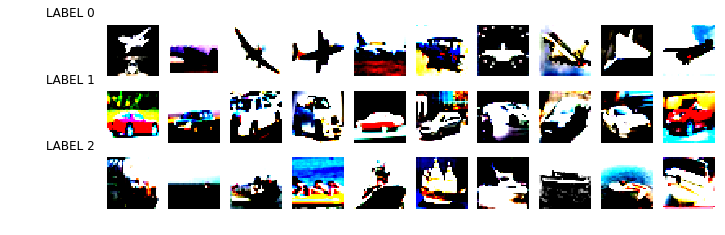

In [17]:
show_image_mosaic(cx_train, y_train)

fíjate cómo mejora la predicción

In [18]:
model = get_model(num_classes)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
model.fit(cx_train, y_train, epochs=5, callbacks=[tensorboard], steps_per_epoch=10)
model.evaluate(cx_test, y_test)

using 3 classes
Epoch 1/5
10/10 [==============================] - 1s 101ms/step - loss: 1.4273 - acc: 0.4839
Epoch 2/5
10/10 [==============================] - 1s 62ms/step - loss: 0.9664 - acc: 0.5684
Epoch 3/5
10/10 [==============================] - 1s 65ms/step - loss: 0.8611 - acc: 0.5997
Epoch 4/5
10/10 [==============================] - 1s 62ms/step - loss: 0.7907 - acc: 0.6293
Epoch 5/5
751/751 [==============================] - 0s 178us/step


[1.0092433621181787, 0.608521971181928]